In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder

This Function Will Be Used Later in the Analysis

In [2]:
#Function for deciding variables using a stepwise selection

def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.01,
                       threshold_out = 0.05,
                       verbose=True):
    """ Perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS

    Arguments:
        X - pandas.DataFrame of numeric features
        y - vector, series of the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions

    Returns: list of selected features

    Example Call: stepwise_selection(X, y)
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print(f'Add  {best_feature} with p-value {best_pval:.4f}')
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Drop {worst_feature} with p-value {worst_pval:.4f}')
        if not changed:
           break
    return included


This code displays the entire dataset. I also decided to drop the Id column since Id number is not an indicator of house price.

In [3]:
#Exploratory Analysis
housing_prices_df = pd.read_csv('Housing_Prices_24.csv')
housing_prices_df = housing_prices_df.drop(columns=['Id'])
housing_prices_df

,SalePrice,LotArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,...,PoolArea,LotConfig,BldgType,YearBuilt,YearRemodAdd,Foundation,CentralAir,KitchenQual,PavedDrive,YrSold
0,208500,8450,856,856,854,2,1,3,8,0,...,0,Inside,1Fam,2003,2003,PConc,Y,Gd,Y,2008
1,181500,9600,1262,1262,0,2,0,3,6,1,...,0,FR2,1Fam,1976,1976,CBlock,Y,TA,Y,2007
2,223500,11250,920,920,866,2,1,3,6,1,...,0,Inside,1Fam,2001,2002,PConc,Y,Gd,Y,2008
3,140000,9550,756,961,756,1,0,3,7,1,...,0,Corner,1Fam,1915,1970,BrkTil,Y,Gd,Y,2006
4,250000,14260,1145,1145,1053,2,1,4,9,1,...,0,FR2,1Fam,2000,2000,PConc,Y,Gd,Y,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,175000,7917,953,953,694,2,1,3,7,1,...,0,Inside,1Fam,1999,2000,PConc,Y,TA,Y,2007
1456,210000,13175,1542,2073,0,2,0,3,7,2,...,0,Inside,1Fam,1978,1988,CBlock,Y,TA,Y,2010
1457,266500,9042,1152,1188,1152,2,0,4,9,2,...,0,Inside,1Fam,1941,2006,Stone,Y,Gd,Y,2010
1458,142125,9717,1078,1078,0,1,0,2,5,0,...,0,Inside,1Fam,1950,1996,CBlock,Y,Gd,Y,2010


This line of code displays statistics on all of the numerical features of the dataset. It is nice to understand the numerical ranges each column has.

In [4]:
housing_prices_df.describe()

,SalePrice,LotArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,YearBuilt,YearRemodAdd,YrSold
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,180921.195890,10516.828082,1057.429452,1162.626712,346.992466,1.565068,0.382877,2.866438,6.517808,0.613014,1.767123,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,1971.267808,1984.865753,2007.815753
std,79442.502883,9981.264932,438.705324,386.587738,436.528436,0.550916,0.502885,0.815778,1.625393,0.644666,0.747315,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,30.202904,20.645407,1.328095
min,34900.000000,1300.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1872.000000,1950.000000,2006.000000
25%,129975.000000,7553.500000,795.750000,882.000000,0.000000,1.000000,0.000000,2.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1954.000000,1967.000000,2007.000000
50%,163000.000000,9478.500000,991.500000,1087.000000,0.000000,2.000000,0.000000,3.000000,6.000000,1.000000,2.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,1973.000000,1994.000000,2008.000000
75%,214000.000000,11601.500000,1298.250000,1391.250000,728.000000,2.000000,1.000000,3.000000,7.000000,1.000000,2.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,2000.000000,2004.000000,2009.000000
max,755000.000000,215245.000000,6110.000000,4692.000000,2065.000000,3.000000,2.000000,8.000000,14.000000,3.000000,4.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,2010.000000,2010.000000,2010.000000


In this block of code, I looked through the Year Sold column, and I kept track of the number of houses sold in each year. I then got all of these year frequencies and created a bar chart displaying the amount of houses sold in each year.

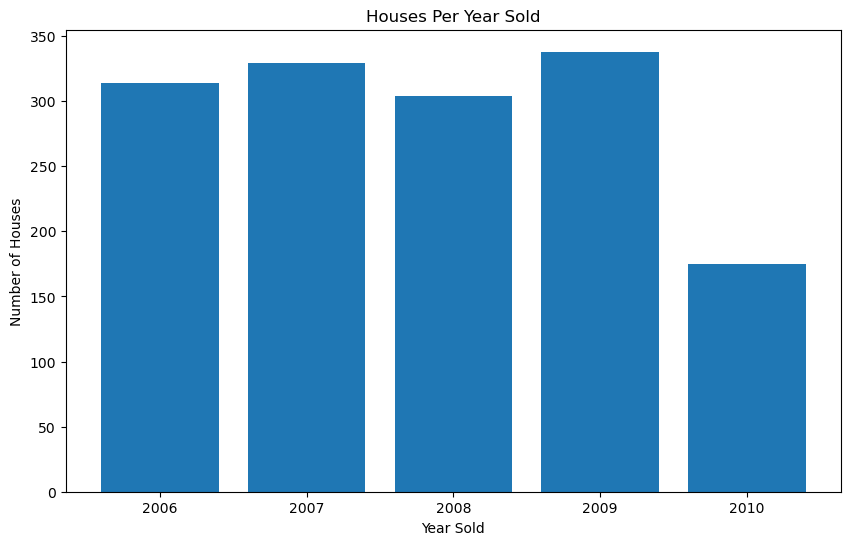

In [5]:
#Data Overview
frequencies = {}
for item in housing_prices_df['YrSold']:
    if item in frequencies:
        frequencies[item] += 1
    else:
        frequencies[item] = 1

frequencies = {'year': [2008, 2007, 2006, 2009, 2010], 'frequency': [304, 329, 314, 338, 175]}
frequency_df = pd.DataFrame.from_dict(frequencies)
frequency_df.head()

#Plot Bar Chart Showing how many houses were sold in each year
plt.figure(figsize=(10,6))
plt.bar(frequency_df['year'], frequency_df['frequency'])
plt.title('Houses Per Year Sold')
plt.xlabel('Year Sold')
plt.ylabel('Number of Houses')
plt.show()

In this block of code, I created a scatter plot comparing year built and year remodeled to sale price. The x-axis is year built, the y-axis is sale price, and the color of the dots indicates year remodeled. 

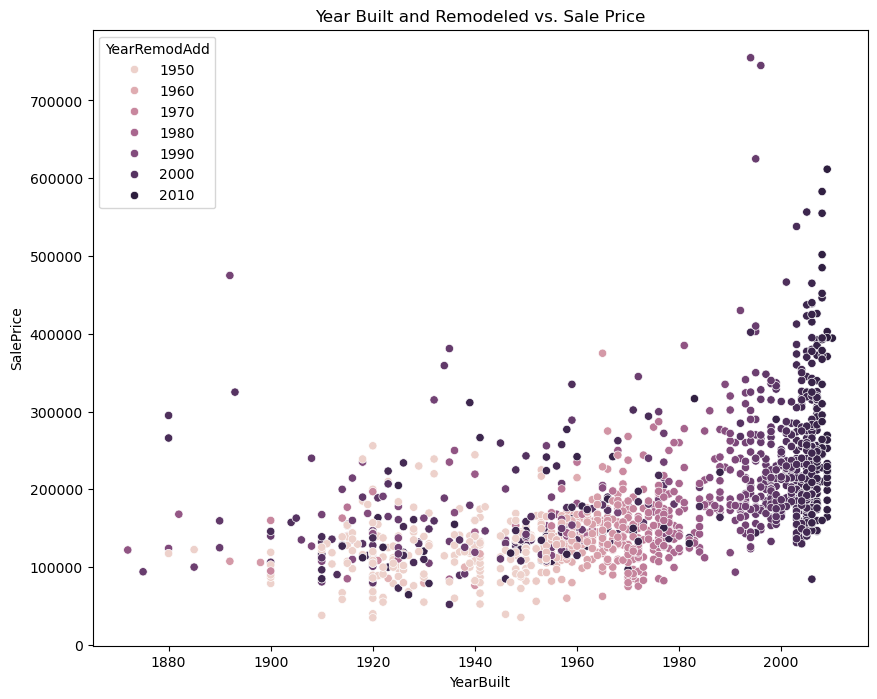

In [6]:
#Analyzing Garage Cars vs. Price
plt.figure(figsize=(10,8))
sns.scatterplot(housing_prices_df, x='YearBuilt', y='SalePrice', hue='YearRemodAdd')
plt.title('Year Built and Remodeled vs. Sale Price')
plt.show()

Check to see if there were any missing values within the dataset.

In [7]:
#Checking for missing values
housing_prices_df.isna().sum()

SalePrice        0
LotArea          0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
FullBath         0
HalfBath         0
BedroomAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageCars       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
LotConfig        0
BldgType         0
YearBuilt        0
YearRemodAdd     0
Foundation       0
CentralAir       0
KitchenQual      0
PavedDrive       0
YrSold           0
dtype: int64

This is the first multiple regression that I performed. In this model, I only used the numeric categories. I did this by listing the categorical columns, looping through the columns in the dataset, and only choosing the columns that were not in my list.

In [8]:
#Preliminary Numeric Regression Analysis
nominal_data = ['LotConfig', 'BldgType', 'Foundation', 'CentralAir', 'KitchenQual', 'PavedDrive']
numeric_data = []
for column in housing_prices_df.columns:
    if column not in nominal_data and column != 'SalePrice':
        numeric_data.append(column)
X = housing_prices_df[numeric_data]
y = housing_prices_df['SalePrice']
X = sm.add_constant(X)

first_regression = sm.OLS(y,X).fit()
print(first_regression.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     233.8
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        15:59:57   Log-Likelihood:                -17517.
No. Observations:                1460   AIC:                         3.507e+04
Df Residuals:                    1440   BIC:                         3.518e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -7.638e+05   1.58e+06     -0.484

This code displays the variance inflation factor for each variable in my regression. I was trying to see if any variables had a high variance inflation factor.

In [9]:
#Preliminary VIF
vifres = pd.DataFrame()

vifres['Variable'] = X.columns
vifres['vif'] = [variance_inflation_factor(X.values, i).round(3) for i in range(X.shape[1])]

print(vifres)

         Variable          vif
0           const  2326984.461
1         LotArea        1.171
2     TotalBsmtSF        3.478
3        1stFlrSF        5.593
4        2ndFlrSF        4.831
5        FullBath        2.639
6        HalfBath        2.136
7    BedroomAbvGr        2.130
8    TotRmsAbvGrd        4.352
9      Fireplaces        1.455
10     GarageCars        1.854
11     WoodDeckSF        1.170
12    OpenPorchSF        1.191
13  EnclosedPorch        1.242
14      3SsnPorch        1.015
15    ScreenPorch        1.094
16       PoolArea        1.062
17      YearBuilt        2.866
18   YearRemodAdd        1.740
19         YrSold        1.015


Thsi code creates a QQ plot and a residual plot for my first regression model. I plotted them using the residuals from the regression model.

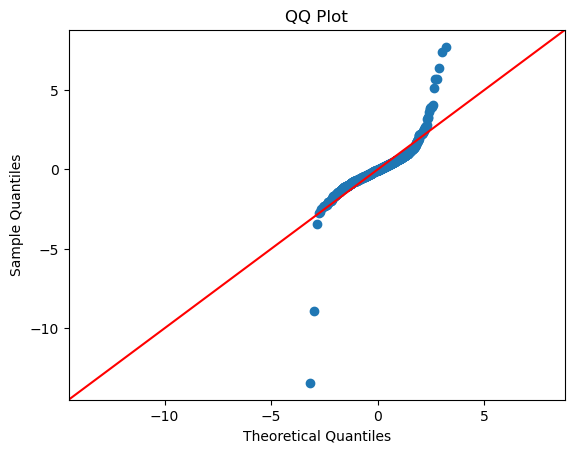

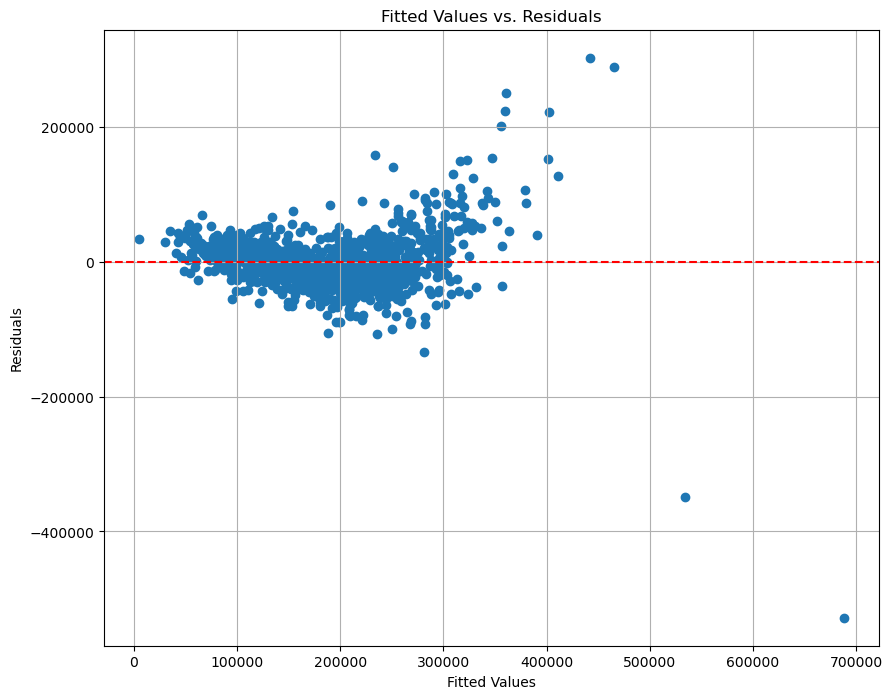

In [10]:
#Preliminary QQ and Residuals
residuals = first_regression.resid

#Q-Q Plot
fig = sm.qqplot(residuals, fit=True, line='45')
plt.title('QQ Plot')
plt.show()

#Residuals
#Scatter Plot
#Fanning Pattern = Non-Constant Variance
plt.figure(figsize=(10,8))
plt.scatter(first_regression.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Fitted Values vs. Residuals')
plt.grid(True)
plt.show()

Here are scatter plots of all the numerical variables plotted against sale price. This gave me an idea of which numerical variables are most significant.

<Figure size 1000x600 with 0 Axes>

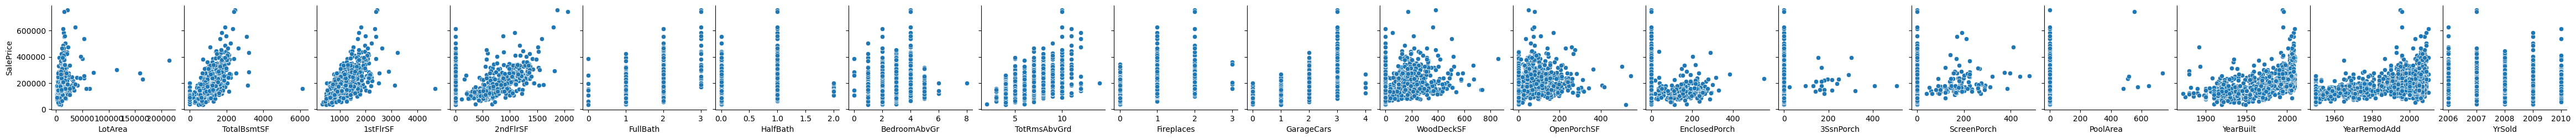

In [11]:
#Numeric Scatter Plots
plt.figure(figsize=(10,6))
sns.pairplot(housing_prices_df, x_vars=numeric_data, y_vars=['SalePrice'])
plt.show()

This accomplishes the same task as the code cell above, but this time I am using a correlation matrix to see which numeric variables are most correlated with the sale price.

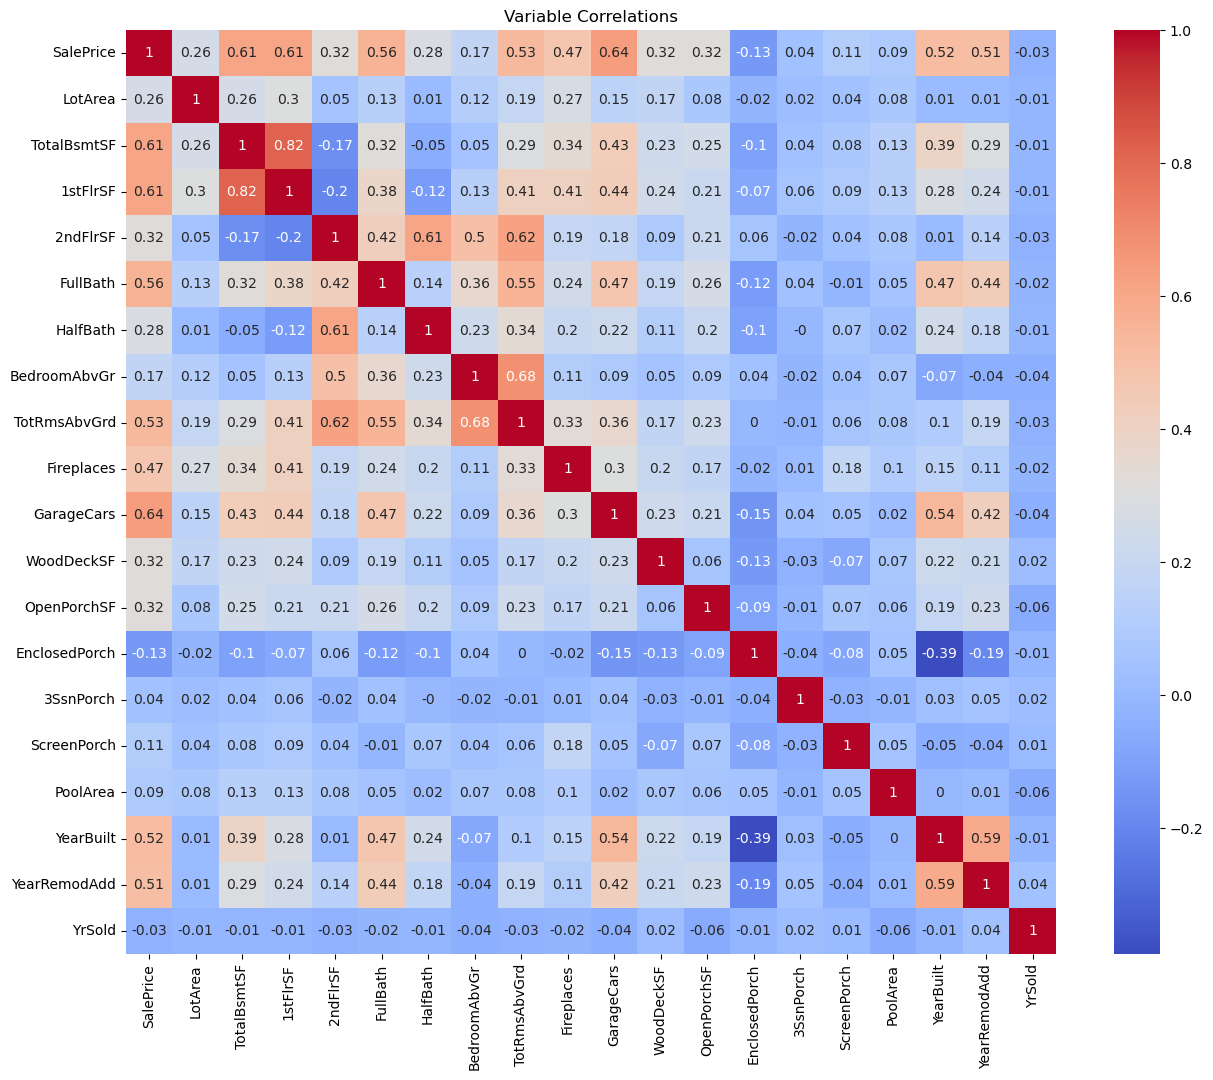

In [12]:
#Correlation Matrix
numeric_df = housing_prices_df.drop(columns=nominal_data)
correl = numeric_df.corr()

correl = correl.round(2)

plt.figure(figsize=(15,12))
sns.heatmap(correl, annot=True, cmap='coolwarm')
plt.title('Variable Correlations')
plt.show()

This code cell uses the function defined at the beginning of the program to automatically drop and choose features that have low p-values. These features are the most influential to the success of the regression model.

In [13]:
#Automated Feature Selection
key_numeric_features = stepwise_selection(X,y)
print(key_numeric_features)

Add  const with p-value 0.0000
Add  GarageCars with p-value 0.0000
Add  TotalBsmtSF with p-value 0.0000
Add  2ndFlrSF with p-value 0.0000
Add  YearRemodAdd with p-value 0.0000
Add  1stFlrSF with p-value 0.0000
Add  YearBuilt with p-value 0.0000
Add  Fireplaces with p-value 0.0000
Add  BedroomAbvGr with p-value 0.0000
Add  WoodDeckSF with p-value 0.0004
Add  ScreenPorch with p-value 0.0009
Add  TotRmsAbvGrd with p-value 0.0014
Add  LotArea with p-value 0.0011
['const', 'GarageCars', 'TotalBsmtSF', '2ndFlrSF', 'YearRemodAdd', '1stFlrSF', 'YearBuilt', 'Fireplaces', 'BedroomAbvGr', 'WoodDeckSF', 'ScreenPorch', 'TotRmsAbvGrd', 'LotArea']


I created box plots to compare each categorical variable to sales price of a house.

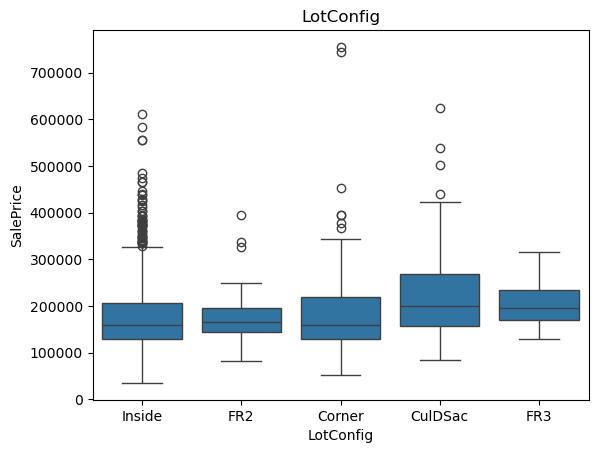

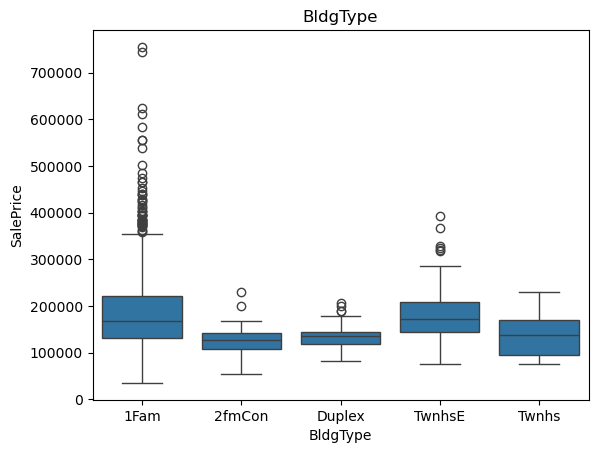

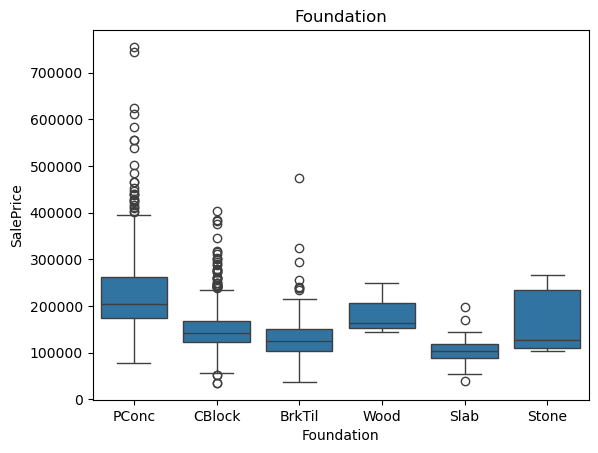

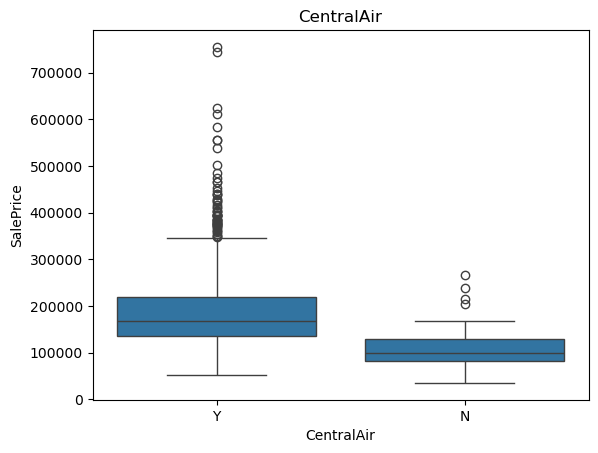

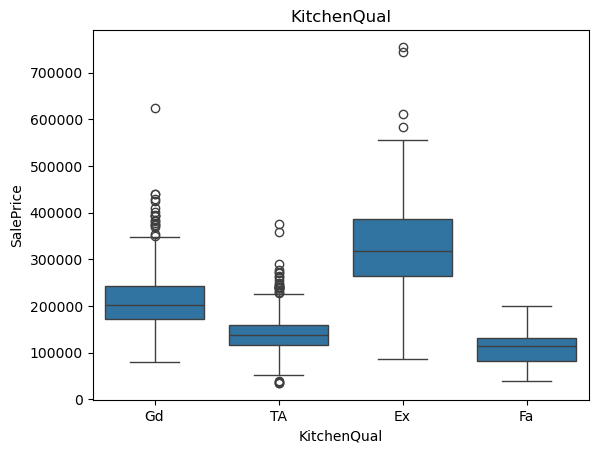

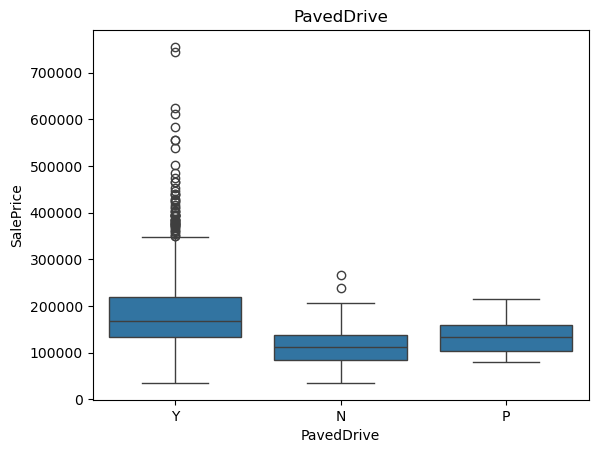

In [14]:
#Box Plots
for column in nominal_data:
    sns.boxplot(x=column, y='SalePrice', data=housing_prices_df)
    plt.title(column)
    plt.show()

I added KitchenQual, CentralAir, and Foundation to the list of columns for the model. They looked like they influenced sales price the most out of all of the categorical variables.

To use these variables in the regression model, I had to create dummy variables for each column.

I also log transformed y since the last residual plot had a fanning shape.

In [15]:
#According to the box plots, it looks like the most influential nominal variables are KitchenQual, CentralAir, and Foundation
nominal_and_numeric = ['KitchenQual', 'CentralAir', 'Foundation', 'GarageCars', 'TotalBsmtSF', '2ndFlrSF', 'YearRemodAdd', 
                       '1stFlrSF', 'YearBuilt', 'Fireplaces', 'BedroomAbvGr', 'WoodDeckSF', 'ScreenPorch', 'TotRmsAbvGrd', 
                       'LotArea']
#Dummy Variables for Nominal inputs
X = housing_prices_df[nominal_and_numeric]
X = pd.get_dummies(X, columns=['KitchenQual', 'CentralAir', 'Foundation'], drop_first=True, dtype='float')
X = sm.add_constant(X)

y = housing_prices_df['SalePrice']
#Since we have a fanning pattern for our residual plot we are going to use a log() scalar for y
logy = np.log(y)

adj_regression = sm.OLS(logy,X).fit()
print(adj_regression.summary())


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     323.1
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:00:02   Log-Likelihood:                 541.53
No. Observations:                1460   AIC:                            -1039.
Df Residuals:                    1438   BIC:                            -922.8
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.0396      0.70

Re-used code to plot the QQ plot and Residual plot.

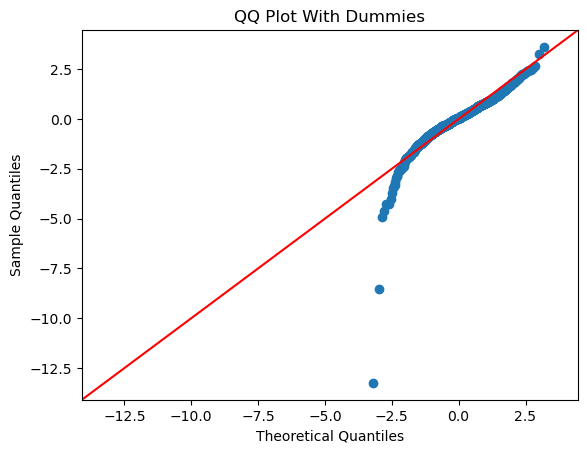

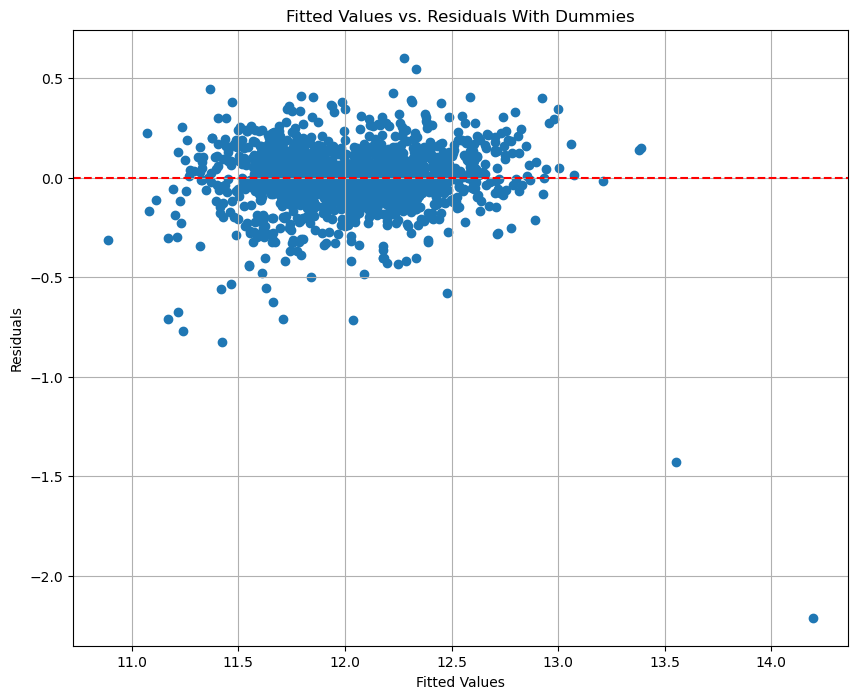

In [16]:
#Re-plot QQ and Residuals
residuals = adj_regression.resid

#Q-Q Plot
fig = sm.qqplot(residuals, fit=True, line='45')
plt.title('QQ Plot With Dummies')
plt.show()

#Residuals
#Scatter Plot
#Fanning Pattern = Non-Constant Variance
plt.figure(figsize=(10,8))
plt.scatter(adj_regression.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Fitted Values vs. Residuals With Dummies')
plt.grid(True)
plt.show()

Since there were large p-values, I used another stepwise variable selection that included the dummy variables. 

In [17]:
#We can make this even better since we still have large p-values
#Re-do automated feature selection
final_features = stepwise_selection(X,logy)
print(final_features)

Add  const with p-value 0.0000
Add  GarageCars with p-value 0.0000
Add  TotalBsmtSF with p-value 0.0000
Add  2ndFlrSF with p-value 0.0000
Add  YearRemodAdd with p-value 0.0000
Add  Fireplaces with p-value 0.0000
Add  YearBuilt with p-value 0.0000
Add  1stFlrSF with p-value 0.0000
Add  CentralAir_Y with p-value 0.0000
Add  KitchenQual_TA with p-value 0.0000
Add  ScreenPorch with p-value 0.0000
Add  WoodDeckSF with p-value 0.0000
Add  KitchenQual_Gd with p-value 0.0002
Add  KitchenQual_Fa with p-value 0.0000
Add  LotArea with p-value 0.0001
Add  Foundation_Slab with p-value 0.0027
Add  Foundation_PConc with p-value 0.0039
['const', 'GarageCars', 'TotalBsmtSF', '2ndFlrSF', 'YearRemodAdd', 'Fireplaces', 'YearBuilt', '1stFlrSF', 'CentralAir_Y', 'KitchenQual_TA', 'ScreenPorch', 'WoodDeckSF', 'KitchenQual_Gd', 'KitchenQual_Fa', 'LotArea', 'Foundation_Slab', 'Foundation_PConc']


Here is my final model using those selected variables.

In [18]:
#Final Regression
final_features.remove('const')
housing_prices_df = pd.get_dummies(housing_prices_df, columns=['KitchenQual', 'CentralAir', 'Foundation'], 
                                   drop_first=True, dtype='float')
X = housing_prices_df[final_features]
X = sm.add_constant(X)

final_regression = sm.OLS(logy, X).fit()
print(final_regression.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     423.5
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:00:03   Log-Likelihood:                 538.57
No. Observations:                1460   AIC:                            -1043.
Df Residuals:                    1443   BIC:                            -953.3
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.2252      0.681  

Here is the VIF score for each of the final features.

In [19]:
#Final VIF Numbers
vifres = pd.DataFrame()

vifres['Variable'] = X.columns
vifres['vif'] = [variance_inflation_factor(X.values, i).round(3) for i in range(X.shape[1])]

print(vifres)

            Variable        vif
0              const  23927.910
1         GarageCars      1.866
2        TotalBsmtSF      4.838
3           2ndFlrSF      1.401
4       YearRemodAdd      2.153
5         Fireplaces      1.450
6          YearBuilt      2.646
7           1stFlrSF      4.527
8       CentralAir_Y      1.324
9     KitchenQual_TA      6.433
10       ScreenPorch      1.068
11        WoodDeckSF      1.153
12    KitchenQual_Gd      4.644
13    KitchenQual_Fa      1.830
14           LotArea      1.180
15   Foundation_Slab      1.471
16  Foundation_PConc      2.222


Re-using code to plot the final QQ plot and Residual Plot.

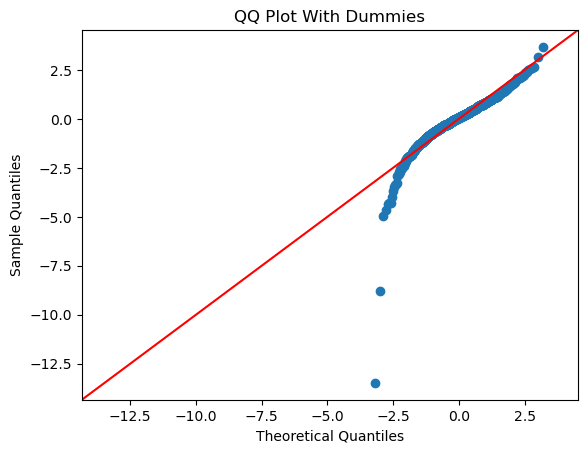

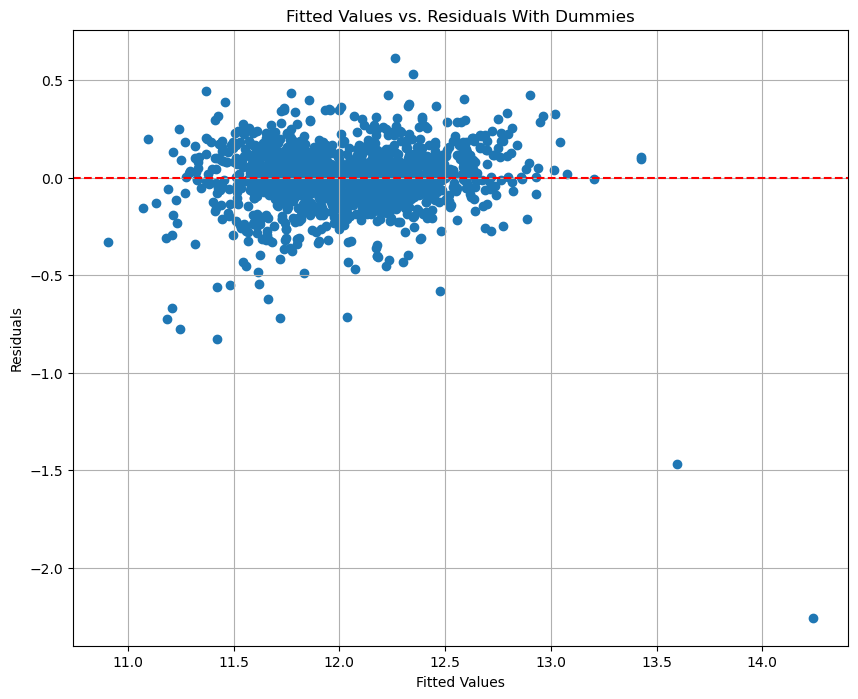

In [20]:
#Re-plot QQ and Residuals
residuals = final_regression.resid

#Q-Q Plot
fig = sm.qqplot(residuals, fit=True, line='45')
plt.title('QQ Plot With Dummies')
plt.show()

#Residuals
#Scatter Plot
#Fanning Pattern = Non-Constant Variance
plt.figure(figsize=(10,8))
plt.scatter(final_regression.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Fitted Values vs. Residuals With Dummies')
plt.grid(True)
plt.show()

This is the dataset containing the homes that we are trying to predict a price for. I dropped the Id column since it is not significant to the regression model.

In [21]:
#Homes that we are trying to sell
homes_for_sale_df = pd.read_csv('homesforsale.csv')
homes_for_sale_df = homes_for_sale_df.drop(columns=['Id'])
homes_for_sale_df

,LotArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,...,PoolArea,LotConfig,BldgType,YearBuilt,YearRemodAdd,Foundation,CentralAir,KitchenQual,PavedDrive,YrSold
0,8450,0,856,854,2,1,3,8,0,2,...,0,Inside,1Fam,2003,2003,PConc,Y,Fa,Y,2011
1,9600,1262,1262,0,2,0,3,6,1,2,...,0,FR2,1Fam,1976,1976,CBlock,Y,TA,Y,2011
2,11250,920,920,866,2,1,3,6,1,2,...,0,Inside,1Fam,2001,2002,PConc,Y,Gd,Y,2011
3,11899,1175,1200,1142,3,1,4,12,2,3,...,0,CulDSac,1Fam,2005,2006,PConc,Y,Ex,Y,2011
4,10791,0,1296,0,2,0,2,6,0,2,...,0,Inside,Duplex,1967,1967,Slab,Y,TA,Y,2011


Included the columns I want to use to predict.

In [22]:
X_new = homes_for_sale_df[nominal_and_numeric]
X_new.head()

,KitchenQual,CentralAir,Foundation,GarageCars,TotalBsmtSF,2ndFlrSF,YearRemodAdd,1stFlrSF,YearBuilt,Fireplaces,BedroomAbvGr,WoodDeckSF,ScreenPorch,TotRmsAbvGrd,LotArea
0,Fa,Y,PConc,2,0,854,2003,856,2003,0,3,0,0,8,8450
1,TA,Y,CBlock,2,1262,0,1976,1262,1976,1,3,298,0,6,9600
2,Gd,Y,PConc,2,920,866,2002,920,2001,1,3,0,0,6,11250
3,Ex,Y,PConc,3,1175,1142,2006,1200,2005,2,4,147,0,12,11899
4,TA,Y,Slab,2,0,0,1967,1296,1967,0,2,0,0,6,10791


Need to change the order of the columns to get the exact prediction of our regression model. I also needed to create a new CentralAir_Y column since pd.dummies will not make a dummy column from a column with only one categorical outcome.

In [23]:
X_new = pd.get_dummies(X_new, columns=['KitchenQual', 'CentralAir', 'Foundation'], drop_first=True, dtype=float)
X_new = sm.add_constant(X_new)
print(X_new.columns)
X_new['CentralAir_Y'] = pd.Series([1,1,1,1,1])
X_new = X_new.drop(columns=['TotRmsAbvGrd', 'BedroomAbvGr'])
X_new = X_new[['const', 'GarageCars', 'TotalBsmtSF', '2ndFlrSF',
               'YearRemodAdd', 'Fireplaces', 'YearBuilt', '1stFlrSF',
               'CentralAir_Y', 'KitchenQual_TA', 'ScreenPorch', 
               'WoodDeckSF', 'KitchenQual_Gd', 'KitchenQual_Fa',
               'LotArea', 'Foundation_Slab', 'Foundation_PConc']]
X_new.head()


Index(['const', 'GarageCars', 'TotalBsmtSF', '2ndFlrSF', 'YearRemodAdd',
       '1stFlrSF', 'YearBuilt', 'Fireplaces', 'BedroomAbvGr', 'WoodDeckSF',
       'ScreenPorch', 'TotRmsAbvGrd', 'LotArea', 'KitchenQual_Fa',
       'KitchenQual_Gd', 'KitchenQual_TA', 'Foundation_PConc',
       'Foundation_Slab'],
      dtype='object')


,const,GarageCars,TotalBsmtSF,2ndFlrSF,YearRemodAdd,Fireplaces,YearBuilt,1stFlrSF,CentralAir_Y,KitchenQual_TA,ScreenPorch,WoodDeckSF,KitchenQual_Gd,KitchenQual_Fa,LotArea,Foundation_Slab,Foundation_PConc
0,1.0,2,0,854,2003,0,2003,856,1,0.0,0,0,0.0,1.0,8450,0.0,1.0
1,1.0,2,1262,0,1976,1,1976,1262,1,1.0,0,298,0.0,0.0,9600,0.0,0.0
2,1.0,2,920,866,2002,1,2001,920,1,0.0,0,0,1.0,0.0,11250,0.0,1.0
3,1.0,3,1175,1142,2006,2,2005,1200,1,0.0,0,147,0.0,0.0,11899,0.0,1.0
4,1.0,2,0,0,1967,0,1967,1296,1,1.0,0,0,0.0,0.0,10791,1.0,0.0


Here are my final predictions for housing prices. I needed to take e to the power of the predictions since I used the log transformation earlier in the notebook.

In [24]:
pred = final_regression.predict(X_new)
print(np.exp(pred))

0    161418.986094
1    161297.027170
2    212537.001614
3    351299.294122
4    111633.533323
dtype: float64


Here is a horizontal bar chart showing the features that positively impacted the sales price, and the columns that negatively impacted the sales price.

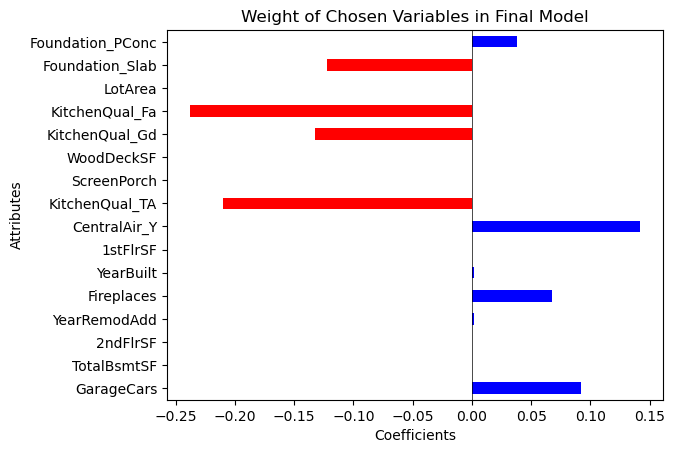

In [25]:
coefficients = final_regression.params
coefficients = coefficients.drop('const')
colors = ['red' if val < 0 else 'blue' for val in coefficients]
coefficients.plot(kind='barh', color=colors)
plt.axvline(x=0, color='black', linewidth=0.5)
plt.xlabel('Coefficients')
plt.ylabel('Attributes')
plt.title('Weight of Chosen Variables in Final Model')
plt.show()
